In [1]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
!pwd

/home/561/erd561/mom/gfdl_nyf_1080_rcp85


In [4]:
figures_path = '/home/561/erd561/figures/SAMexp/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

nyf_path = '/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/'
ctrl_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
hist5069_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
rcp85_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/'




Figures will be saved in: /home/561/erd561/figures/SAMexp/t02_SST_taux_diff



In [5]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: scheduler='tcp://127.0.0.1:40766' processes=8 cores=8>
CPU times: user 1.01 s, sys: 217 ms, total: 1.22 s
Wall time: 14 s


In [6]:
# ice_daily, ice_month, ocean_bgc_2d, ocean_bgc_carbon, ocean_bgc_daily,
# ocean_bgc_npzd, ocean_cfc, ocean_force, ocean_global, ocean_month, ocean_surface

nyf_years = np.arange(477, 487)
ctrl_years = np.arange(566, 576)
# hist5069_years = np.arange(501, 576)
rcp85_years = np.arange(602, 621)

nyf_years_len = len(nyf_years)
ctrl_years_len = len(ctrl_years)
# hist5069_years_len = len(hist5069_years)
rcp85_years_len = len(rcp85_years)

years = np.concatenate([
    np.arange(1-nyf_years_len, 0), 
    np.arange(0, ctrl_years_len+1), 
    np.arange(ctrl_years_len+1, ctrl_years_len+1 + rcp85_years_len)])
print(years)
print(len(years))

# 1. SST
var1 = 'ice_month'
path1 = []

# 2. tx and ty trans
var21 = 'ocean'
var22 = 'ocean_month'
path2 = []

# var31 = 'ocean'
# var32 = 'ocean_month'
# path3 = []

for y in nyf_years:
    path1.append(nyf_path + 'output' + str(y) + '/' + var1 + '.nc')
    path2.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
#     path3.append(remote_path_ctrl + 'output' + str(y) + '/' + var31 + '.nc')

for y in ctrl_years:
    path1.append(ctrl_path + 'output' + str(y) + '/' + var1 + '.nc')
    path2.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')

for y in rcp85_years:
    path1.append(rcp85_path + 'output' + str(y) + '/' + var1 + '.nc')
    path2.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')


for p1,p2 in zip(path1,path2):
    print(p1)
    print(p2)
#     print(p3)


[-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
39
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ice_month.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ice_month.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ice_month.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ice_month.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ice_month.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ice_month.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ice_month.nc
/g/data/v45/pas56

In [117]:
%%time

sst = []
for p1,p2 in zip(path1, path2):
    if p1 == path1[0]:
        sst = \
            xr.open_dataset(p1, decode_times=False).\
            SST.\
            mean(dim='time')
        
        taux = \
            xr.open_dataset(p2, decode_times=False).\
            tau_x.\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))
        
        print(str(p1) + ' OK')
            
    elif 'v45' in p1:
        sst = \
            xr.concat([
                sst,
                xr.open_dataset(p1, decode_times=False).\
                SST.\
                mean(dim='time')
            ], 'year'
            )
        
        taux = \
            xr.concat([
                taux,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))
            ], 'year'
            )
        print(str(p1) + ' OK')
        
    else:
        sst = \
            xr.concat([
                sst,
                xr.open_dataset(p1, decode_times=False).\
                SST.\
                mean(dim='time')
            ], 'year'
            )
        
        taux = \
            xr.concat([
                taux,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                mean(dim='time')
            ], 'year'
            )
        print(str(p1) + ' OK')
print(sst.shape)

sst = sst.assign_coords(year=years)
taux = taux.assign_coords(year=years)



/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ice_month.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ice_month.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ice_month.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ice_month.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ice_month.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ice_month.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ice_month.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output484/ice_month.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output485/ice_month.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output486/ice_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ice_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ice_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ice_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/

In [144]:
sst_nyf = sst.sel(year=slice(-9,0)).mean(dim='year')
sst_hist5069 = sst.sel(year=slice(1,10)).mean(dim='year')
sst_rcp85 = sst.sel(year=slice(11,20)).mean(dim='year')

taux_nyf = taux.sel(year=slice(-9,0)).mean(dim='year')
taux_hist5069 = taux.sel(year=slice(1,10)).mean(dim='year')
taux_rcp85 = taux.sel(year=slice(11,20)).mean(dim='year')

<xarray.DataArray 'SST' (yt: 2028, xt: 2880)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt       (xt) float64 -279.9 -279.9 -279.7 -279.6 -279.4 -279.4 -279.2 ...
  * yt       (yt) float64 -81.08 -81.08 -80.97 -80.97 -80.87 -80.87 -80.76 ...
<xarray.DataArray 'SST' (yt: 2028, xt: 2880)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt       (xt) float64 -279.9 -279.9 -279.7 -279.6 -279.4 -279.4 -279.2 ...
  * yt       (yt) float64 -81.08 -81.08 -80.97 -80.97 -80.87 

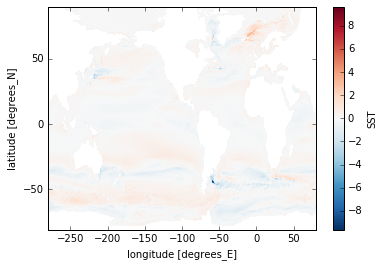

In [139]:
print(sst_hist5069)
print(sst_nyf)

(sst_rcp85-sst_rcp85).plot()

SST ($^{\circ}C$) anomaly rcp85 - hist5069
TAU X ($N\ m^{-2}$) anomaly rcp85 - hist5069


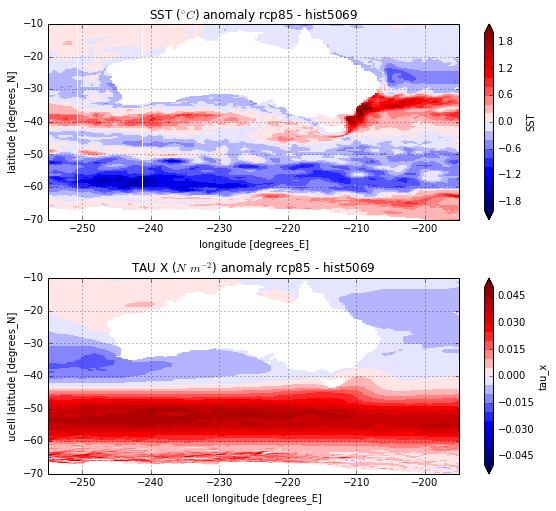

In [150]:
lon = [105, 165]
lat = [-70, -10] 

plt.close('all')
fig = plt.figure() 
fig.set_size_inches(8,8)                    


plt.subplot(2,1,1)
cont_lev = np.arange(-2,2.2,0.2)
anom = sst_rcp85 - sst_hist5069
cont = anom.plot(levels=cont_lev, cmap=plt.cm.seismic, extend='both')
plt.xlim([lon[0]-360, lon[1]-360])
plt.ylim([lat[0], lat[1]])
plt.grid()
title = 'SST ($^{\circ}C$) anomaly rcp85 - hist5069'
plt.title(title)
print(title)  


plt.subplot(2,1,2)
cont_lev = np.arange(-0.05,0.055,0.005)
anom = taux_rcp85 - taux_hist5069
cont = anom.plot(levels=cont_lev, cmap=plt.cm.seismic, extend='both')
plt.xlim([lon[0]-360, lon[1]-360])
plt.ylim([lat[0], lat[1]])
plt.grid()
title = 'TAU X ($N\ m^{-2}$) anomaly rcp85 - hist5069'
plt.title(title)
print(title)  


fig.tight_layout(rect=[0, 0, 1, 0.90])

output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_.png', bbox_inches='tight', dpi=200)

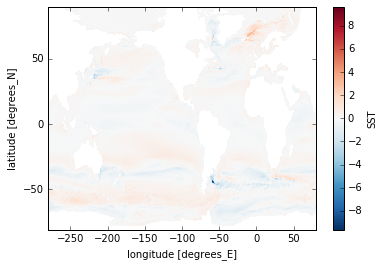

In [153]:
(sst_hist5069-sst_rcp85).plot()